In [2]:
from NN import *
from LTL import *


from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
import os
from matplotlib import pyplot as plt

from ipywidgets.widgets import IntSlider
from ipywidgets import interact

Number of Omega-automaton states (including the trap state): 5


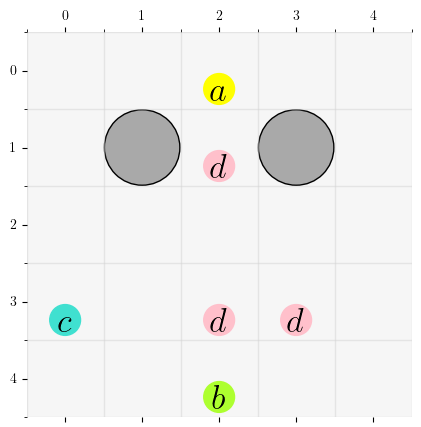

In [4]:
### from the Nursary case ###
# LTL Specification
# ltl = ('G ('
#     '(!d) & '
#     '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
#     '(((!b) & (X b) & (!(X X b)))->((!a) U c)) & '
#     '(a->(X ((!a) U b))) & '
#     '(c->((!a) U b)) & '
#     '((b & (X b))->(F a))'
# ')')

ltl = ("(G !d) & ((!c) U b) & ((!b) U a) & (F c)")

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,5)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E',  'E'],
['E',  'B',  'E',  'B',  'E'],
['E',  'E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('a',),    (),    ()],
[(),    (),    ('d',),(),    ()],
[(),    (),    (),    (),    ()],
[('c',),(),    ('d',),('d',),()],
[(),    (),    ('b',),(),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=1, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot(save="env.pdf")

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)


In [3]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 5, 5)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 5, 32)     672         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 5, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 200)          0           ['conv2d_1[0][0]']               
                                                                                              

In [4]:
t = "[] ~d /\ (~c % b) /\ (~b % a) /\ (<> c)"

LTL_formula = parser.parse(t)
predicates={'a':[2], 'b':[22], 'c':[15], 'd':[7,17,18]}

In [5]:
LTL_formula

('/\\',
 ('[]', ('~', (None, 'd'))),
 ('/\\',
  ('%', ('~', (None, 'c')), (None, 'b')),
  ('/\\', ('%', ('~', (None, 'b')), (None, 'a')), ('<>', (None, 'c')))))

In [6]:
model(csrl.ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [7]:

num_epochs = 20
training = True
T = 16
results = []
search_depths = [2,4,8,16,32,40,60,80,100,120,140,160] #[2,4,6,8,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120]
for sd in search_depths:
    wins = 0
    N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)
    for epoch in range(num_epochs):
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=sd,
                verbose=4,start=(0,0),T=T,K=3)
        if check_LTL(LTL_formula, trajectory, predicates)[0]:
            wins+=1
            print(check_LTL(LTL_formula, trajectory, predicates))

        if training:
            x_train = np.array(channeled_states)
            y1_train = np.array(better_policy)
            y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
            model.fit(x_train[:-1], [y1_train, y2_train[:-1]], epochs=20, verbose=0)

    ###############################################################
    print("Wins:",wins,"/",num_epochs)
    print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    print("Actions:", action_history)
    results.append(wins)

trajectory: [0, 1, 1, 1, 2, 3, 4, 9, 14, 13, 14, 19, 14, 19, 18]
action_history: [2, 0, 1, 2, 2, 2, 1, 1, 3, 2, 1, 0, 1, 3]
state history: [(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 2), (0, 1, 0, 3), (0, 1, 0, 4), (0, 1, 1, 4), (0, 1, 2, 4), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 3, 4), (0, 1, 2, 4), (0, 1, 3, 4), (0, 1, 3, 3)]
----------
trajectory: [0, 0, 1, 2, 1, 0, 5, 5, 5, 10, 5, 0, 0, 0, 1, 1]
action_history: [3, 2, 2, 3, 3, 1, 3, 2, 1, 0, 0, 0, 3, 2, 1]
state history: [(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 1, 0, 1), (0, 1, 0, 0), (0, 1, 1, 0), (0, 1, 1, 0), (0, 1, 1, 0), (0, 1, 2, 0), (0, 1, 1, 0), (0, 1, 0, 0), (0, 1, 0, 0), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 1)]
----------
trajectory: [0, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 0, 0, 1]
action_history: [0, 2, 2, 0, 3, 3, 2, 1, 2, 0, 3, 1, 3, 0, 2]
state history: [(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 1, 0, 2), (0, 1, 0, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 1),

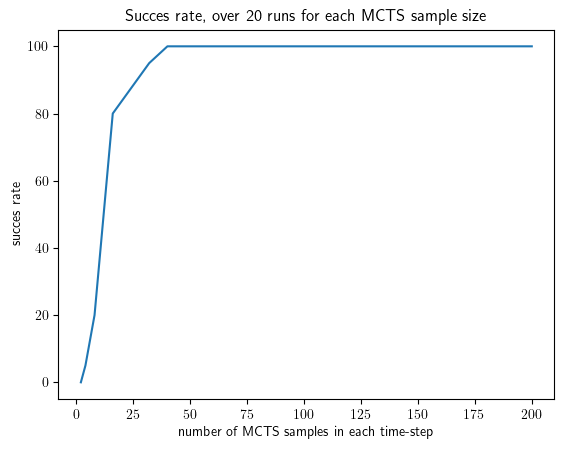

In [18]:
plt.plot(search_depths, [0]+[r*5 for r in results[:-1]])
plt.xlabel("number of MCTS samples in each time-step")
plt.ylabel("succes rate")
plt.title("Succes rate, over 20 runs for each MCTS sample size")
plt.savefig('line_plot.pdf') 

In [9]:
def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_agent(t)>

In [ ]:
os.system('ffmpeg -r 3 -i ./test/%d.png -vcodec libx264 -y ./test/test.mp4')

1

In [ ]:
os.sep

'\\'